In [8]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time

from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from sklearn.svm import LinearSVC
%matplotlib inline

In [40]:
#feauture extraction helpers
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features
    
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [62]:
#Get features of a image
def feature_extract_image(feature_image,
                    spatial_features,
                    histogram_features,
                    hog_features,
                    hist_bins,
                    orient,
                    pix_per_cell,
                    cell_per_block,
                    hog_channel):
    features = []
    if spatial_features == True:
        spatial_featuresures = bin_spatial(feature_image, size=spatial_size)
        features.append(spatial_featuresures)
    if histogram_features == True:
        histogram_featuresures = color_hist(feature_image, nbins=hist_bins)
        features.append(histogram_featuresures)
    if hog_features == True:
        if hog_channel == 'ALL':
            hog_featuresures = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel],
                                        orient, pix_per_cell, cell_per_block,
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_featuresures)
        else:
            feature_image = cv2.cvtColor(feature_image, cv2.COLOR_LUV2RGB)
            feature_image = cv2.cvtColor(feature_image, cv2.COLOR_RGB2GRAY)
            hog_featuresures = get_hog_features(feature_image[:,:], orient,
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        features.append(hog_featuresures)
    return features

def feature_extract(imgs,
                        color_space='RGB',
                        spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feature=True, hist_feature=True, hog_feature=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for img_file in imgs:
        file_features = []
        image = cv2.imread(img_file)
        #If color space is not RGB perform conversion to specified colorspace
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)
        file_features = feature_extract_image(feature_image, spatial_feature, hist_feature, hog_feature, hist_bins, orient,
                        pix_per_cell, cell_per_block, hog_channel)
        features.append(np.concatenate(file_features))
        #Data augmentation : Lets flip the images, just to have more data
        feature_image=cv2.flip(feature_image,1)
        file_features = feature_extract_image(feature_image, spatial_feature, hist_feature, hog_feature, hist_bins, orient,
                        pix_per_cell, cell_per_block, hog_channel)
        features.append(np.concatenate(file_features))
    return features # Return list of feature vectors

In [76]:
# Read in cars and notcars

import glob

images = glob.glob('*vehicles/*/*')
cars = []
noncars = []
for image in images:
    if 'non' in image:
        noncars.append(image)
    else:
        cars.append(image)

#size = 1000
#cars = cars[0:size]
#noncars = noncars[0:size]
#print(len(cars))
#print(len(noncars))

In [55]:
#Exploring color spaces
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation




Color space Exploration
By plotting the 3D plot of car and non car images, it is clear that HSV and LUV
are able to pick up the color saturation better than RGB. Picking LUV over HSV as
the plot of LUV seem more seperable compared to HSV.TODO: Check performance of classifier between HSV and LUV
and decide

In [72]:
#Print some non car 3D plots
img = cv2.imread("colorSpaceStuff/noncar.png")

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

img_small_LUV = cv2.cvtColor(img_small, cv2.COLOR_BGR2LUV)
# Plot and show
plot3d(img_small_RGB, img_small_rgb)
plt.show()

plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plt.show()

plot3d(img_small_LUV, img_small_rgb, axis_labels=list("LUV"))
plt.show()

AttributeError: 'str' object has no attribute 'shape'

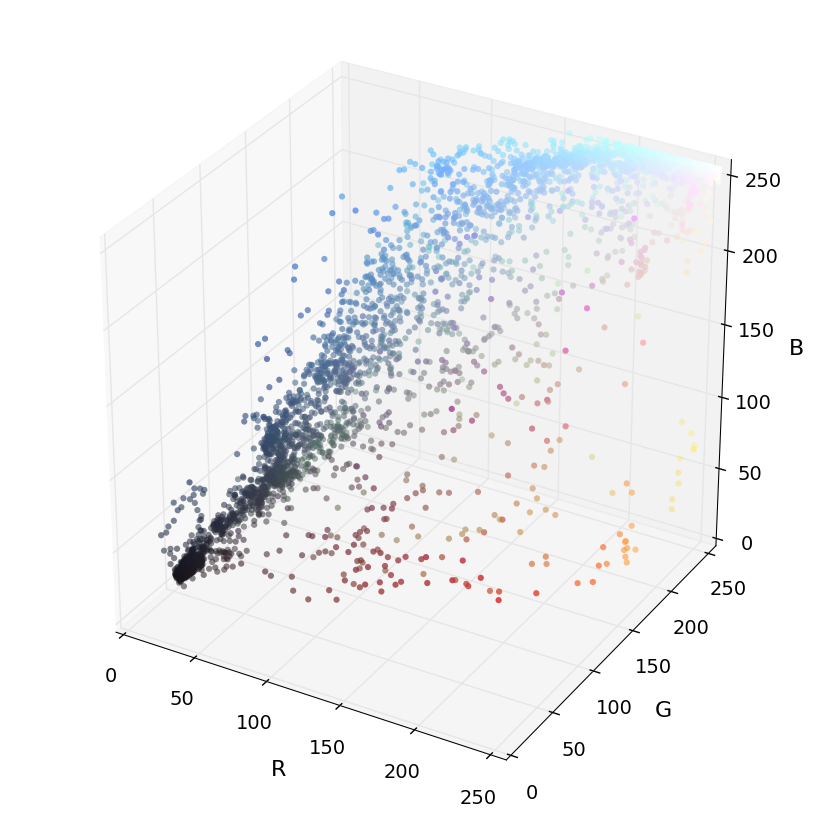

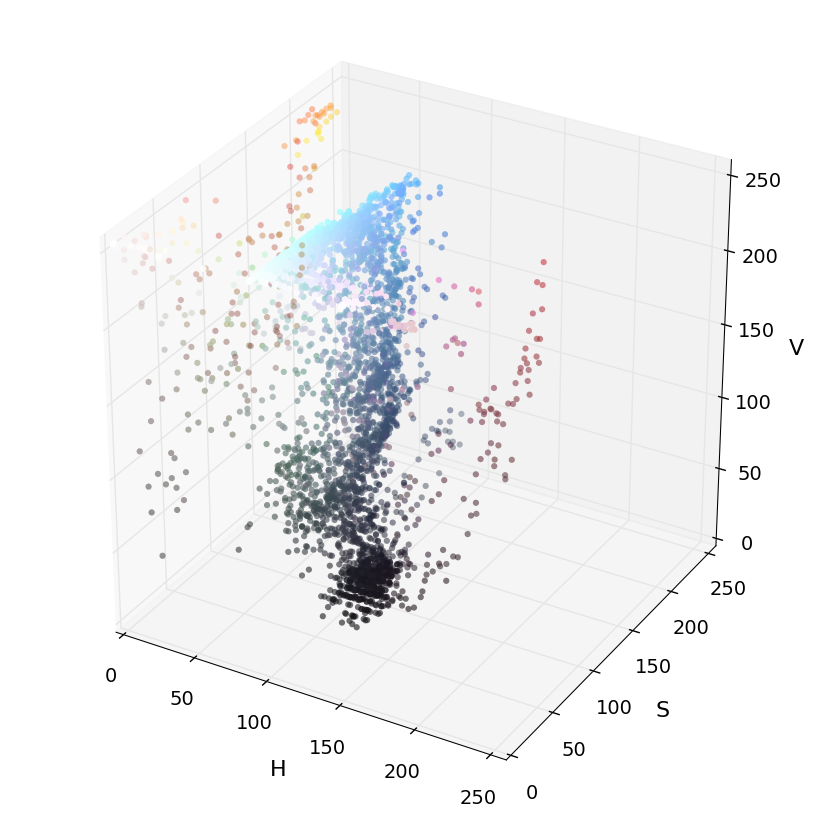

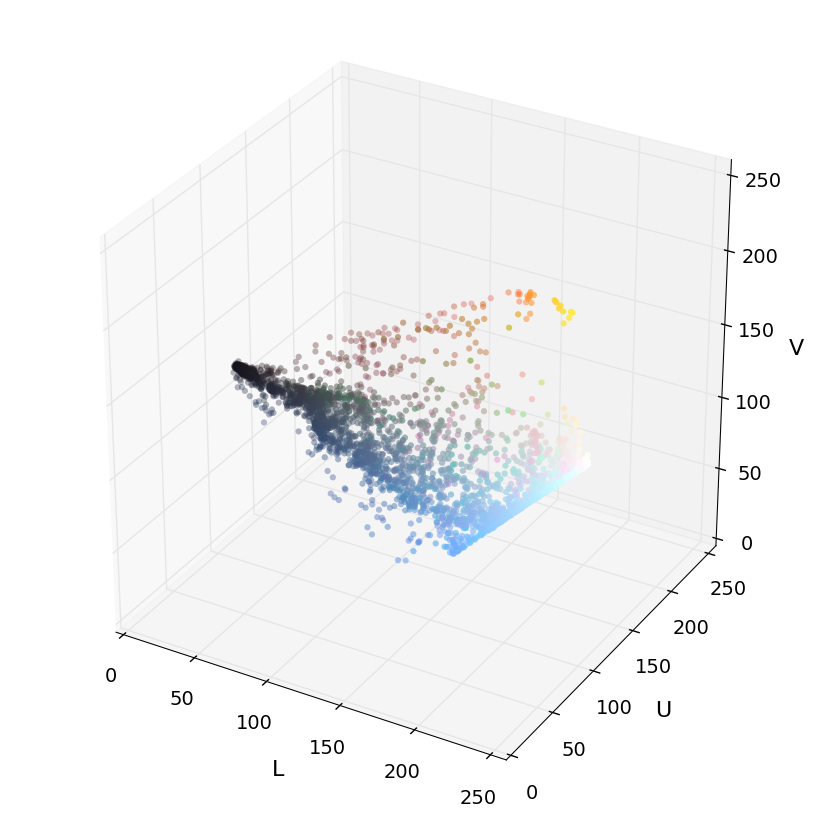

In [54]:
#Print some  car 3D plots
img = cv2.imread("colorSpaceStuff/car3.png")

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

img_small_LUV = cv2.cvtColor(img_small, cv2.COLOR_BGR2LUV)
# Plot and show
plot3d(img_small_RGB, img_small_rgb)
plt.show()

plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plt.show()

plot3d(img_small_LUV, img_small_rgb, axis_labels=list("LUV"))
plt.show()

In [80]:
#Train a SVM classifier
#LUV Classifier accuracy =  0.988316441441
#RBG Classifier accuracy =  0.985078828829
#HSV Classifier accuracy =  0.974521396396

#Below are the parameters for feature exraction
color_space='LUV'
hog_channel = 0
orient = 8 
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 #0,1,22,ALL
spatial_size = (16, 16) # spatial bin dimensions
hist_bins = 32
#Set to TRUE/FALSE to enable/disable respective feature
spatial_features= True 
hist_features = True 
hog_features = True

#Extract CAR feautures

car_features = None
car_features = feature_extract(cars,
                        color_space,
                        spatial_size,
                        hist_bins, 
                        orient,
                        pix_per_cell, 
                        cell_per_block,
                        hog_channel,
                        spatial_features,
                        hist_features, 
                        hog_features)


#Extract non CAR features
non_car_features = None
non_car_features = feature_extract(noncars,
                        color_space,
                        spatial_size,
                        hist_bins, 
                        orient,
                        pix_per_cell, 
                        cell_per_block,
                        hog_channel,
                        spatial_features,
                        hist_features, 
                        hog_features)

print("car features length ",len(car_features))
print("non car features length ",len(non_car_features))

#Create input feature vector
X = np.vstack((car_features, non_car_features)).astype(np.float64) 

scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

#Label vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

svc = LinearSVC(loss='hinge')
svc.fit(X_train, y_train) # Train the classifier
print ("Classifier accuracy = ",svc.score(X_test, y_test))

car features length  17584
non car features length  17936
Classifier accuracy =  0.988316441441


In [82]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def draw_boxes(image, bboxes, color=(0, 255, 0), thick=6):
    imcopy = np.copy(image) # Make a copy of the image
    for bbox in bboxes: # Iterate through the bounding boxes
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

In [97]:
def feat_extractor_img(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)
    #9) Return concatenated array of features
    return np.concatenate(img_features)

"""Searches all the input windows cars.
    Returns a list of windows which have cars"""
def window_search(img,windows,
                  color_space,
                  orient,
                  pix_per_cell,
                  cell_per_block,
                  hog_channel,
                  spatial_size,
                  hist_bins,
                  spatial_features,
                  hist_features,
                  hog_features):
     positive_windows=[]
     for window in windows:
      #Get the pixel data for the window in question
        window_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))

          #Extract features for this window
        features = feat_extractor_img(window_img,
            color_space,
            spatial_size,
            hist_bins,
            orient,
            pix_per_cell,
            cell_per_block,
            hog_channels,
            spatial_features,
            hist_features,
            hog_features)
   #Scale the features
        window_features = scaler.transform(np.array(features).reshape(1, -1))
        is_car = clf.predict(window_features)
        
        if(is_car == 1):
            positive_windows.append(window)
        
     return positive_windows
      


sample_images/videofile123.jpg
0
sample_images/videofile178.jpg
4
sample_images/videofile382.jpg
2
sample_images/videofile414.jpg
3
sample_images/videofile678.jpg
1
sample_images/videofile987.jpg
11


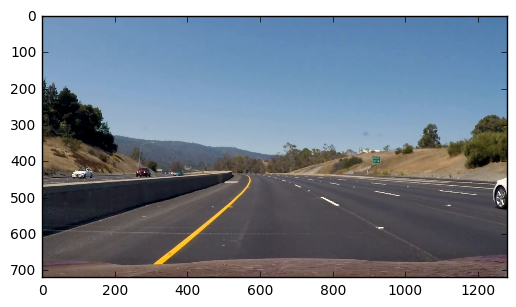

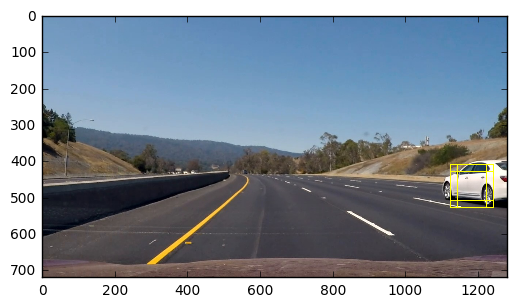

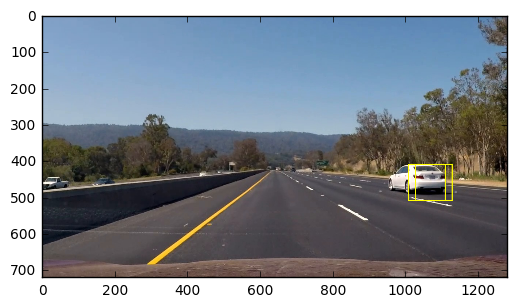

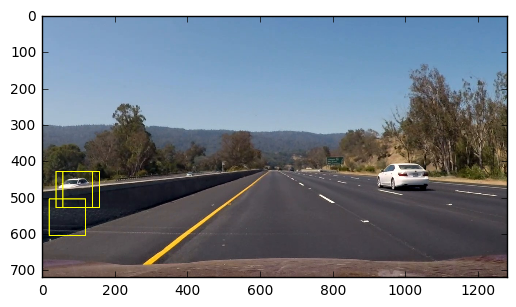

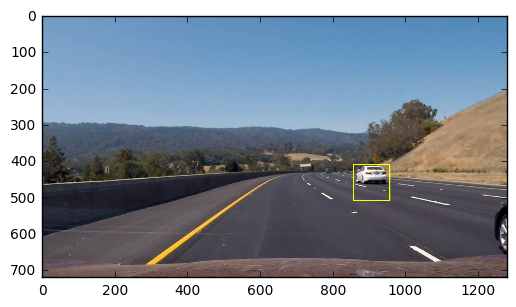

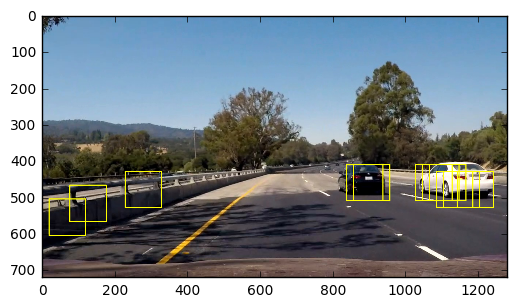

In [111]:
for image_p in glob.glob('sample_images/*.jpg'):
    print(image_p)
    image = cv2.imread(image_p)
    draw_image = np.copy(image)
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[410, 630], 
                    xy_window=(100, 100), xy_overlap=(0.8, 0.8))
    car_windows = []
    car_windows += (search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat))  
    print(len(car_windows))
    window_img = draw_boxes(draw_image, car_windows, color=(0,255, 255), thick=2)
    show_img(window_img)

At this point, the window detection works, but it has the following issues
a) Cars not getting detected (Reason? Probably because they are too far off, window size doesn't match the
   car size?
b) False detection. 
c) Multiple detection windows on a car

<ipython-input-32-c955ca4957f6>:68: SyntaxWarning: name 'n_count' is used prior to global declaration
  global heat_p, boxes_p, n_count


TypeError: 'NoneType' object is not subscriptable